**João Lucas Lage Gonçalves**

**23052002**

# Descrição


# Carregar os dados

In [1]:
%pip install matplotlib
%pip install socceraction



Note: you may need to restart the kernel to use updated packages.


In [2]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
import socceraction.spadl as spadl
from socceraction.data.wyscout import PublicWyscoutLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\jllgo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
DATA_DIR = 'data'
WYL = PublicWyscoutLoader(root=DATA_DIR)
TRAIN_COMPETITIONS = ['German first division', 'Italian first division', 'French first division', 'Spanish first division', 'English first division']
TEST_COMPETITIONS = ['World Cup', 'European Championship']

competitions = WYL.competitions()

train_competions = competitions[competitions.competition_name.isin(TRAIN_COMPETITIONS)]
test_competions = competitions[competitions.competition_name.isin(TEST_COMPETITIONS)]

# Load all matches of the training competitions
train_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in train_competions.itertuples()
])

print(train_games.head())

test_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in test_competions.itertuples()
])

test_games.head()


   game_id  competition_id  season_id           game_date  game_day  \
0  2576335             524     181248 2018-05-20 18:45:00        38   
1  2576336             524     181248 2018-05-20 18:45:00        38   
2  2576329             524     181248 2018-05-20 16:00:00        38   
3  2576330             524     181248 2018-05-20 16:00:00        38   
4  2576331             524     181248 2018-05-20 16:00:00        38   

   home_team_id  away_team_id  
0          3162          3161  
1          3315          3158  
2          3173          3172  
3          3165          3219  
4          3163          3166  


,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,1694440,102,9291,2016-07-10 19:00:00,0,9905,4418
1,1694439,102,9291,2016-07-07 19:00:00,0,3148,4418
2,1694438,102,9291,2016-07-06 19:00:00,0,9905,10682
3,1694437,102,9291,2016-07-03 19:00:00,0,4418,7839
4,1694436,102,9291,2016-07-02 19:00:00,0,3148,3757


In [4]:
games_verbose = list(train_games.itertuples())

training_actions = []
for game in tqdm(games_verbose, desc="Converting training games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    training_actions.append(actions_game)

training_df = pd.concat(training_actions).reset_index(drop=True)

Converting training games to SPADL (1826 games): 100%|██████████| 1826/1826 [24:04<00:00,  1.26it/s]    


In [5]:
games_verbose = list(test_games.itertuples())

test_actions = []
for game in tqdm(games_verbose, desc="Converting test games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    test_actions.append(actions_game)

test_df = pd.concat(test_actions).reset_index(drop=True)

Converting test games to SPADL (115 games): 100%|██████████| 115/115 [00:28<00:00,  4.00it/s]


In [6]:
training_df.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id
0,2576335,1,2.417590,3161,3344,51.45,34.00,39.90,28.56,253668302,0,0,1,0,pass,success,foot,3162
1,2576335,1,3.904412,3161,116349,39.90,28.56,38.85,6.12,253668303,0,0,1,1,pass,success,foot,3162
2,2576335,1,6.484211,3161,135903,38.85,6.12,35.70,19.04,253668304,0,0,1,2,pass,success,foot,3162
3,2576335,1,10.043835,3161,138408,35.70,19.04,37.80,58.48,253668306,0,0,1,3,pass,success,foot,3162
4,2576335,1,14.032070,3161,21094,37.80,58.48,31.50,41.48,253668308,0,0,1,4,pass,success,foot,3162


In [7]:
players = pd.read_json(DATA_DIR+'\players.json')
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


In [8]:
teams = pd.read_json(DATA_DIR+'\\teams.json')
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


# Tratamento de dados

In [9]:
test_games['game_date'] = pd.to_datetime(test_games['game_date'])
train_games['game_date'] = pd.to_datetime(train_games['game_date'])

test_date = test_games['game_date'].min()
train_date = train_games['game_date'].min()

print(f"Train date: {train_date}")
print(f"Test date: {test_date}")

Train date: 2017-08-04 18:45:00
Test date: 2016-06-10 19:00:00


In [10]:
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players['player_country'] = players['passportArea'].apply(lambda x: x['name'] if x is not None else None)
players['birthDate'] = pd.to_datetime(players['birthDate'])
players['train_age'] = (train_date - players['birthDate']).dt.days // 365
players['test_age'] = (test_date - players['birthDate']).dt.days // 365

players['player_name'] = players['player_name'].str.decode('unicode-escape')
players['player_country'] = players['player_country'].str.decode('unicode-escape')
players['shortName'] = players['shortName'].str.decode('unicode-escape')
players = players.rename(columns={'wyId': 'player_id', 'currentTeamId': 'team_id'})

players = players[['player_id', 'player_name', 'shortName', 'player_country', 'train_age', 'test_age', 'team_id']]

players.head()

,player_id,player_name,shortName,player_country,train_age,test_age,team_id
0,32777,Harun Tekin,H. Tekin,Turkey,28,27,4502
1,393228,Malang Sarr,M. Sarr,Senegal,18,17,3775
2,393230,Over Mandanda,O. Mandanda,France,18,17,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,27,26,683
4,393247,Ibrahima Konaté,I. Konaté,France,18,17,2975


In [11]:
teams['team_country'] = teams['area'].apply(lambda x: x['name'] if x is not None else None)
teams['name'] = teams['name'].str.decode('unicode-escape')
teams['team_country'] = teams['team_country'].str.decode('unicode-escape')

teams = teams.rename(columns={'wyId': 'team_id', 'name': 'team_name'})

teams = teams[['team_id', 'team_name', 'team_country']]

teams.head()

,team_id,team_name,team_country
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo Alavés,Spain
4,695,Levante,Spain


# EDA

<Axes: >

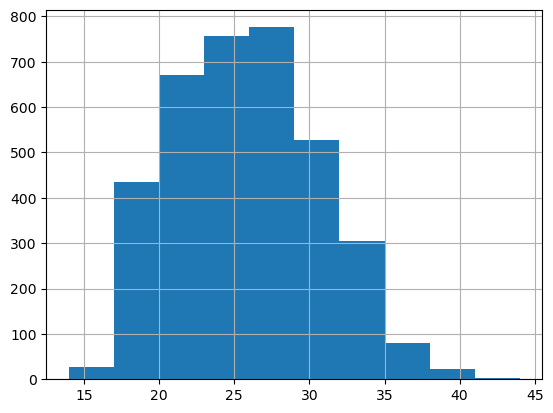

In [12]:
players['train_age'].hist()

# Feature Engeneering

In [13]:
from socceraction.vaep import features as ft
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def createFeatures(actions):
    actions.loc[actions.result_id.isin([2, 3]), ['result_id']] = 0
    actions.loc[actions.result_name.isin(['offside', 'owngoal']), ['result_name']] = 'fail'
    spadl_features = [
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.movement,
        ft.space_delta,
        ft.startpolar,
        ft.endpolar,
        ft.team,
        ft.time,
        ft.time_delta
    ]
    
    features = []
    for game in tqdm(actions.game_id.unique(), desc="Creating features"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        match_states = ft.gamestates(actions=actions_game,nb_prev_actions=3)
        match_states = ft.play_left_to_right(match_states,actions_game.home_team_id.unique()[0])
        match_features = pd.concat([fn(match_states) for fn in spadl_features], axis=1)
        features.append(match_features)
    
    features = pd.concat(features).reset_index(drop=True)
    bp_other = [c for c in list(features.columns) if 'bodypart' in c and 'foot' not in c]
    non_success = [c for c in list(features.columns) if 'result' in c and 'success' not in c]
    non_action = [c for c in list(features.columns) if 'non_action' in c]
    keeper = [c for c in list(features.columns) if 'keeper' in c and 'save' not in c]
    
    features = features.drop(bp_other + non_success + non_action + keeper, axis=1)
    return features

In [14]:
training_features = createFeatures(training_df)
test_features = createFeatures(test_df)

print(training_features.head())
test_features.head()

Creating features: 100%|██████████| 115/115 [00:06<00:00, 17.65it/s]


   actiontype_pass_a0  actiontype_cross_a0  actiontype_throw_in_a0  \
0                True                False                   False   
1                True                False                   False   
2                True                False                   False   
3                True                False                   False   
4                True                False                   False   

   actiontype_freekick_crossed_a0  actiontype_freekick_short_a0  \
0                           False                         False   
1                           False                         False   
2                           False                         False   
3                           False                         False   
4                           False                         False   

   actiontype_corner_crossed_a0  actiontype_corner_short_a0  \
0                         False                       False   
1                         False                   

,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,4.782709,4.782709,1.0,4.782709,4.782709,1.0,4.782709,4.782709,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,6.973876,6.973876,1.0,4.782709,4.782709,1.0,4.782709,4.782709,2.191167,2.191167
2,True,False,False,False,False,False,False,False,False,False,...,9.531543,9.531543,1.0,6.973876,6.973876,1.0,4.782709,4.782709,2.557667,4.748834
3,True,False,False,False,False,False,False,False,False,False,...,10.575710,10.575710,1.0,9.531543,9.531543,1.0,6.973876,6.973876,1.044167,3.601834
4,True,False,False,False,False,False,False,False,False,False,...,13.624168,13.624168,1.0,10.575710,10.575710,1.0,9.531543,9.531543,3.048458,4.092625


# Gerando Labels

In [15]:
import socceraction.vaep.labels as lb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def createLabels(actions):
    spadl_labels = [
         lb.scores,
         lb.concedes
     ]
    
    labels = []
    for game in tqdm(actions.game_id.unique(), desc="Creating labels"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        labels.append(pd.concat([fn(actions=actions_game) for fn in spadl_labels], axis=1))
    
    labels = pd.concat(labels).reset_index(drop=True)
    return labels

In [16]:
training_labels = createLabels(actions=training_df)
test_labels = createLabels(actions=test_df)

print(training_labels.head())
test_labels.head()

Creating labels: 100%|██████████| 115/115 [00:02<00:00, 46.36it/s]

   scores  concedes
0   False     False
1   False     False
2   False     False
3   False     False
4   False     False


,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


# Model Creation   

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score


class AdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, n_estimators=50):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, _ = X.shape
        y = np.array(y)  # Garantir que y é um array NumPy
        w = np.ones(n_samples) / n_samples  # Inicializar pesos
        for _ in range(self.n_estimators):
            model = self.base_classifier.__class__(**self.base_classifier.get_params())  # Nova instância
            model.fit(X, y, sample_weight=w)
            y_pred = model.predict(X)
            err_m = np.sum(w * (y_pred != y)) / np.sum(w)
            alpha_m = np.log((1 - err_m) / err_m) / 2

            self.models.append(model)
            self.alphas.append(alpha_m)

            w *= np.exp(-alpha_m * y * y_pred)
            w /= np.sum(w)

    def predict(self, X):
        model_preds = np.array([alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models)])
        y_pred = np.sign(np.sum(model_preds, axis=0))
        return y_pred
    
    def predict_proba(self, X):
        model_preds = np.array([alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models)])
        proba = (np.sum(model_preds, axis=0) + 1) / 2
        return np.vstack((1 - proba, proba)).T
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)[:, 1]
        brier = brier_score_loss(y, y_proba)
        logloss = log_loss(y, y_proba)
        rocauc = roc_auc_score(y, y_proba)
        accuracy = accuracy_score(y, y_pred)
        
        print("Model Evaluation")
        print("================")
        print(f"Brier score: {brier:.4f}")
        print(f"Log loss: {logloss:.4f}")
        print(f"ROC AUC: {rocauc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("================")
        
        return {
            'brier_score': brier,
            'log_loss': logloss,
            'roc_auc': rocauc,
            'accuracy': accuracy
        }

    def summary(self):
        print("AdaBoost Model Summary")
        print("======================")
        print(f"Number of estimators: {self.n_estimators}")
        print(f"Base classifier: {self.base_classifier.__class__.__name__}")
        print(f"Max depth of base classifiers: {self.base_classifier.get_params().get('max_depth', 'N/A')}")
        print(f"Number of fitted models: {len(self.models)}")
        print("Alpha values (model weights):")
        for i, alpha in enumerate(self.alphas):
            print(f"  Model {i+1}: {alpha:.4f}")
        print("======================")


In [19]:
%pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 660.6 kB/s eta 0:03:10
   ---------------------------------------- 0.2/124.9 MB 2.8 MB/s eta 0:00:46
   ---------------------------------------- 0.6/124.9 MB 4.8 MB/s eta 0:00:26
   ---------------------------------------- 1.4/124.9 MB 9.0 MB/s eta 0:00:14
    --------------------------------------- 2.3/124.9 MB 12.0 MB/s eta 0:00:11
    --------------------------------------- 2.6/124.9 MB 12.0 MB/s eta 0:00:11
   - -------------------------------------- 3.5/124.9 MB 12.4 MB/s eta 0:00:10
   - -------------------------------------- 4.5/124.9 MB 13.5 MB/s eta 0:00:09
   - -------------------------------------- 4.9/124.9 MB 13.5 MB/s eta 0:00:09
   - ----------

In [20]:
import xgboost as xgb
base_clf = DecisionTreeClassifier(max_depth=5)
ada_clf = AdaBoostClassifier(base_classifier=base_clf, n_estimators=100)

ada_clf = xgb.XGBClassifier(n_estimators=100, max_depth=9, n_jobs=-3, verbosity=1)
# ada_clf.summary()

# Train, Test and Evaluation

In [21]:
from sklearn.base import clone
def train_model(model, features, labels):
    models = {}
    for label in tqdm(labels.columns):
        print("Training model for {}".format(label))
        model_copy = clone(model)  # Clonar o modelo para evitar reutilização do mesmo objeto
        models[label] = model_copy.fit(features, labels[label])
        
        #models[label].summary()  # Chamar a função summary do modelo treinado
    
    return models

In [22]:
def test_model(models, features, labels):
    predictions = {}
    for label in tqdm(labels.columns):
        print("Testing model for {}".format(label))
        predictions[label] = models[label].predict(features)
    
    return predictions

In [28]:
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    brier = brier_score_loss(y, y_proba)
    logloss = log_loss(y, y_proba)
    rocauc = roc_auc_score(y, y_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print("Model Evaluation")
    print("================")
    print(f"Brier score: {brier:.4f}")
    print(f"Log loss: {logloss:.4f}")
    print(f"ROC AUC: {rocauc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("================")
    
    return {
        'brier_score': brier,
        'log_loss': logloss,
        'roc_auc': rocauc,
        'accuracy': accuracy
    }

In [34]:
def evaluate_model(models, features, labels):
    for label in labels.columns:
        print(f"Results for {label}")
        get_metrics(models[label], features, labels[label])
        

In [35]:
#models = train_model(ada_clf, training_features, training_labels)
#predictions = test_model(models, test_features, test_labels)
evaluate_model(models, test_features, test_labels)

Results for scores
Model Evaluation
Brier score: 0.0119
Log loss: 0.0634
ROC AUC: 0.7252
Accuracy: 0.9878
Results for concedes
Model Evaluation
Brier score: 0.0057
Log loss: 0.0345
ROC AUC: 0.6727
Accuracy: 0.9943
